In [1]:
#IMPORTS
import warnings
import pandas as pd
import h5py
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import sys
import os
import scipy.signal as sgn
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
import umap
from sklearn.metrics import silhouette_score
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import HDBSCAN
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, BatchNormalization, ELU, Input
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
sys.path.append('../../Pre-processing')  
from filters import ecg_filtrado

c:\Users\luisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
autoencoder = tf.keras.models.load_model('../modelos/luisa_autoencoder_model_18.keras')

In [3]:
#CARREGAR OS DADOS
caminho_arquivo = "../../Database/exams.csv"
dados = pd.read_csv(caminho_arquivo)

ecg_normal_linhas = dados.index[((dados.iloc[:, 14] == "exams_part17.hdf5") | (dados.iloc[:, 14] == "exams_part16.hdf5") ) & (dados.iloc[:, 13] == True) ]
ecg_doente_linhas = dados.index[((dados.iloc[:, 14] == "exams_part17.hdf5") | (dados.iloc[:, 14] == "exams_part16.hdf5") ) & (dados.iloc[:, 4] == False) & (dados.iloc[:, 5] == False) & (dados.iloc[:, 6] == False) & (dados.iloc[:, 7] == False) & (dados.iloc[:, 8] == False) & (dados.iloc[:, 9] == True)  ]

ecg_doente_id = dados.iloc[ecg_doente_linhas, 0].tolist()
ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()

ecg_doente = ecg_doente_id[:500]
ecg_normal = ecg_normal_id[:10000]

ids_ecgs= ecg_doente + ecg_normal
ids_ecgs_treino = ecg_normal_id[10001:11001] + ecg_doente_id[501:551]

In [4]:
#X
def get_ecg_data(file_path, exam_id):
    with h5py.File(file_path, 'r') as f:
        # Obter os IDs dos exames
        exam_ids = np.array(f['exam_id'])

        # Encontrar o índice correspondente ao exam_id de interesse
        exam_index = np.where(exam_ids == exam_id)[0]

        if len(exam_index) == 0:
            raise ValueError("Exam ID não encontrado.")
        else:
            exam_index = exam_index[0]
            # Acessar os tracings de ECG correspondentes ao exam_index
            exam_tracings = f['tracings'][exam_index]
            return exam_tracings
        
# Caminho para o arquivo HDF5
path_to_file = '../../Database/filtered_exams_16_17.hdf5'  # Substitua pelo caminho real do arquivo

exam_ids_to_cluster = ids_ecgs  # Substitua pelos IDs reais dos exames

# Lista para armazenar todos os tracings de ECG
all_tracings = []

# Obter os tracings de ECG para cada exam_id e armazenar na lista
for exam_id in exam_ids_to_cluster:
    tracings = get_ecg_data(path_to_file, exam_id)
    aa = np.array(tracings.T)
    all_tracings.append(aa)

# X será um array com um único array dentro, contendo todos os números do tracings.T
X = np.array(all_tracings)
 
# Usando squeeze
X = np.squeeze(X[:, 1, :])



In [5]:
#DIMINUIR DIMENSAO DE X PELO AUTOENCODER(128)

# Extrair o modelo encoder a partir do autoencoder treinado
encoder = autoencoder.get_layer("encoder")

# Normalizar os dados entre 0 e 1 para um melhor desempenho do autoencoder
X = X / np.max(np.abs(X), axis=1, keepdims=True)

# Redimensionar os dados para o formato esperado pelo modelo (10500, 4096, 1)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Obter os vetores codificados para todo o conjunto X
X_encoded = encoder.predict(X)

# X_encoded agora contém os vetores de 128 números para cada entrada em X
print(X_encoded.shape)  # Deve ser (10500, 128, 1)

# Remover a última dimensão para obter um vetor 2D
X_encoded_2d = np.squeeze(X_encoded)
print(X_encoded_2d.shape)  # Deve ser (10500, 128)

328/328 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
(10496, 128, 1)
(10496, 128)


In [21]:
#DIMINUIR DIMENSAO DE X PELO UMAP(16)
warnings.filterwarnings('ignore', message="n_jobs value.*overridden to 1 by setting random_state.*")
# Normalizar os dados
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_encoded_2d)
# Aplicação do UMAP
umap_reducer = umap.UMAP(n_neighbors=4, min_dist=0.0, n_components=16, random_state=42)
X_reduced = umap_reducer.fit_transform(X_normalized)

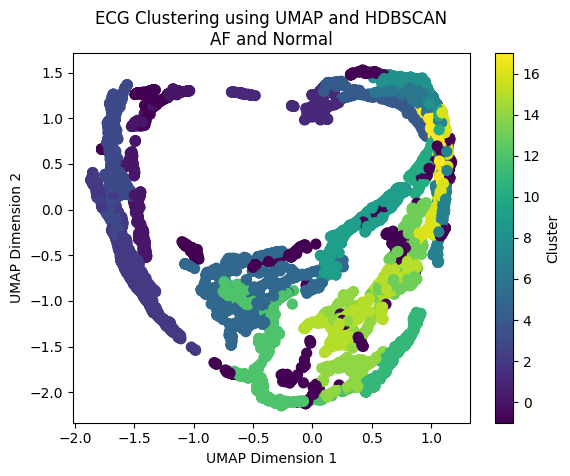

Silhouette Score: 0.30565252900123596
    cluster  1dAVb  RBBB  LBBB  SB  ST   AF  normal_ecg
0        -1      0     0     0   0   0   38        1166
1         0      0     0     0   0   0   12         396
2         1      0     0     0   0   0  166         349
3         2      0     0     0   0   0   27         832
4         3      0     0     0   0   0   33         910
5         4      0     0     0   0   0   16         307
6         5      0     0     0   0   0   24         809
7         6      0     0     0   0   0    5         217
8         7      0     0     0   0   0   19         892
9         8      0     0     0   0   0   17         467
10        9      0     0     0   0   0   30         549
11       10      0     0     0   0   0    8         395
12       11      0     0     0   0   0    5         293
13       12      0     0     0   0   0   15         588
14       13      0     0     0   0   0   14         379
15       14      0     0     0   0   0    9         330
16       1

In [27]:
#CLUSTERIZACAO HDBSCAN
scaler = StandardScaler()
X_reduced_scaled = scaler.fit_transform(X_reduced)

dbscan = HDBSCAN(min_cluster_size=200, min_samples=5)
labels = dbscan.fit_predict(X_reduced_scaled)
# Visualização dos Resultados
plt.scatter(X_reduced_scaled[:, 0], X_reduced_scaled[:, 1], c=labels, cmap='viridis', s=50)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('ECG Clustering using UMAP and HDBSCAN\nAF and Normal')
plt.colorbar(label='Cluster')
plt.show()
silhouette_avg = silhouette_score(X_reduced_scaled, labels)
print(f'Silhouette Score: {silhouette_avg}')


# Carregar os dados do CSV
metadata = pd.read_csv("../../Database/exams.csv")

# Criar um DataFrame para os resultados do clustering
cluster_results = pd.DataFrame({
    'exam_id': exam_ids_to_cluster,
    'cluster': labels
})

# Mesclar os resultados do clustering com os metadados dos exames
merged_data = cluster_results.merge(metadata, on='exam_id')

# Contar a quantidade de doenças e ECGs normais em cada cluster
cluster_summary = merged_data.groupby('cluster').agg({
    '1dAVb': 'sum',
    'RBBB': 'sum',
    'LBBB': 'sum',
    'SB': 'sum',
    'ST': 'sum',
    'AF': 'sum',
    'normal_ecg': 'sum'
}).reset_index()

# Mostrar o resumo por cluster
print(cluster_summary)